# Learnability Project: PFA Phonotactic Learner

------

## General functions and other stuff

In [295]:
from pyfoma import FST, State
from math import log, exp

lam = "λ"


def data_iterator(path):
    """Yield a word as a list of tokens"""
    with open (path, "r") as fin:
        for line in fin.readlines():
            yield line.split()
            
            
def make_alphabet(path) -> list:
    """This function extracts an alphabet from a corpusl"""
    alph = []
    for word in data_iterator(path):
        for sym in word:
            if sym not in alph:
                alph.append(sym)
    return alph

## Strictly 2-Local DFA Creation

In [252]:
def make_SL2_dfa(alphabet:list) -> list[FST]:
    """This function initializes a 2-SL DFA according to an alphabet. All weights are set to 0 by default"""
    
    # create the FST object and instantiate the initial state
    dfa = FST()
    q0 = dfa.initialstate
    q0.finalweight = 0
    q0.name = lam
    states = {q0,}
    
    # initialize all states and connect q0 to them
    for sym in alphabet:
        q = State()
        q.name = sym
        q0.add_transition(q, sym, 0)
        states.add(q)
        q.finalweight = 0
    
    # loopify the states, excluding q0
    states_no_q0 = set([s for s in states if s.name != lam])
    for state1 in states_no_q0:
        for state2 in states_no_q0:
            state1.add_transition(state2, state2.name, 0)
    
    dfa.states      = states
    dfa.finalstates = states
    dfa.alphabet    = alphabet
    
    return [dfa]

## Strictly 2-Piecewise Creation

In [229]:
def make_SP2_dfas(alphabet:list) -> list[FST]:
    """This function intitializes 2SP machines according the length of the alphabet"""
    SP2_machines = []
    
    # initializes all 2 state machines and loopify them
    for sym1 in alphabet:
        dfa             = FST()
        q0              = dfa.initialstate
        q0.finalweight  = 0
        q0.name         = lam
        q1              = State()
        q1.finalweight  = 0
        q1.name         = sym1
        dfa.states      = {q0, q1}
        dfa.finalstates = {q0, q1}
        dfa.alphabet    = alphabet
        q0.add_transition(q1, sym1, 0)
        
        # loopification
        for sym2 in alphabet:
            if sym1 != sym2:
                q0.add_transition(q0, sym2, 0)
            
            q1.add_transition(q1, sym2, 0)
        
        SP2_machines.append(dfa)
     
    return SP2_machines

## MLE

In [307]:
def update_transitions(dfas:list[FST], path:str) -> list[FST]:
   
    for word in data_iterator(path):
        for dfa in dfas:
            cs = dfa.initialstate # gets set back to q0 when a new word is processed
            
            for token in word:
                for _, trans in cs.all_transitions():

                    if trans.label == token: # find the transition that matches the current token
                        trans.weight += 1
                        
                    if token == trans.targetstate.name: # update cs to transition's target state. This is how we "traverse" the states
                        cs = trans.targetstate
                                 
            cs.finalweight += 1 # update the weight of the last state the current string ends in
            
    return dfas

def get_trans_sum(state):
    """sums all the transition weights (counts) and the finalweight for given state """
    return sum([tran.weight for _, tran in state.all_transitions()])


def assert_sum_to_1(dfa:FST) -> None:
    """This functoion asserts that each state's transition weights sum to 1"""
    for state in dfa.states:
        try:
            total = get_trans_sum(state) + state.finalweight
            assert total > .99 # accounts for floating point precision

        except AssertionError:
            print(f"State: {state.name} is misbehaving!\nWeighted sum: {total} != 1\n")
            raise RuntimeError

def MLE(dfas:list[FST], path:str) -> list[FST]:
    """This function takes one or more dfas, updates the weights from a corpus, and normalizes"""
    dfas = update_transitions(dfas, path)
    
    for dfa in dfas:
        
        # list of state weight sums for current dfa
        all_state_trans_sums = [get_trans_sum(state) + state.finalweight for state in dfa.states] 
        

        for i, state in enumerate(dfa.states):
            for _, trans in state.all_transitions():

                #  normalize transition weight by sum of the state's transition weights
                trans.weight = (trans.weight) / all_state_trans_sums[i]

            state.finalweight = (state.finalweight / all_state_trans_sums[i])

        assert_sum_to_1()
        
            

    return dfas

## Playground

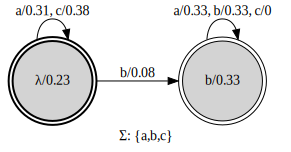

In [309]:
# Learning data paths
debug   = "data/eric_debugging_data.txt"
toy     = "data/LearningData.txt"
navajo  = "data/LearningData_navajo.txt"
quechua = "data/LearningData_quechua.txt"

toy_alph = make_alphabet(toy)
debug_alph = make_alphabet(debug)

db_SL2     = make_SL2_dfa(debug_alph)
db_SL2_MLE = MLE(db_SL2, debug)


db_SP2     = make_SP2_dfas(debug_alph)
db_SP2_MLE = MLE(db_SP2, debug)

db_SP2_MLE[1].view()



sum log probs along path given string

